# Electricity Prediction Analysis - Phase 2: Advanced Optimization

Goal: Minimize Mean Absolute Percentage Error (MAPE) using advanced Data Science techniques.

## Plan
1.  **Deep EDA**: Decompose time series to understand trend/seasonality.
2.  **Advanced Feature Engineering**:
    *   **Lags**: t-6 (original), plus t-24 (daily), t-168 (weekly).
    *   **Cyclical Time**: sin/cos encoding for Hours.
    *   **Rolling Statistics**: Rolling mean/std to capture volatility.
3.  **Model Training**:
    *   **Linear Regression** (Baseline)
    *   **XGBoost** (Gradient Boosting for non-linearities)
    *   **LSTM** (Recurrent Neural Network for sequence modeling)
4.  **Comparison**: Final ranking by MAPE.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Setup Paths
data_path = Path().cwd().parent / "data" / "electricity_prediction.csv"
report_path = Path().cwd().parent / "report" / "figures"
report_path.mkdir(parents=True, exist_ok=True)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Data Loading & Preprocessing

In [2]:
try:
    # Load data without header
    df = pd.read_csv(data_path, header=None)
    
    # Assign names temporarily for understanding
    # The user defined: First 6 columns = Input Hours, 7th column = Target (Hour 7)
    column_names = [f'Lag_{7-i}' for i in range(1, 7)] + ['Target']
    df.columns = column_names
    
    # For Time Series Analysis, we essentially need a single univariate series of 'Target'.
    # The features provided (Lag_6 to Lag_1) are just previous values of Target.
    # We will reconstruct the full 'Time Series' from Target to perform proper Feature Engineering.
    # (Assuming rows are sequential hours)
    
    data_series = df['Target']
    print(f"Data loaded. Total samples: {len(df)}")
    
except FileNotFoundError:
    print("Error: File not found.")

Data loaded. Total samples: 139571


## 2. Deep EDA: Decomposition & Correlation

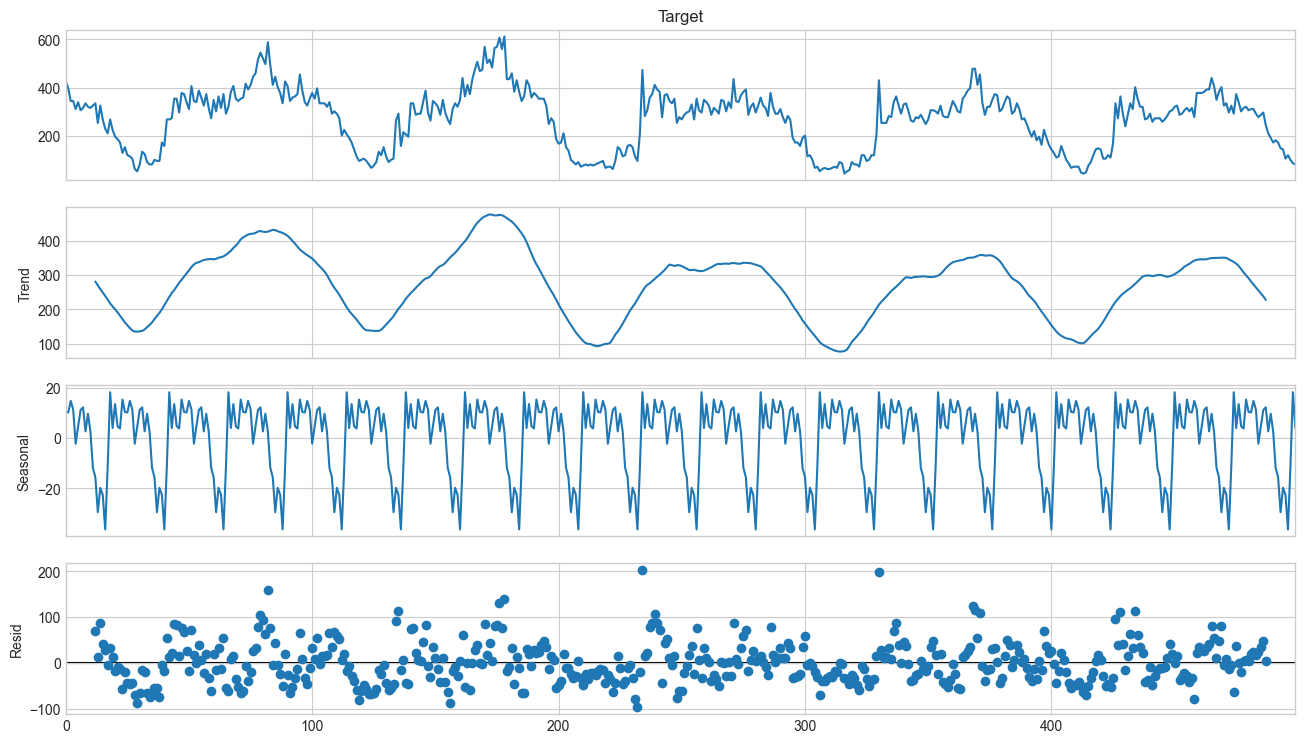

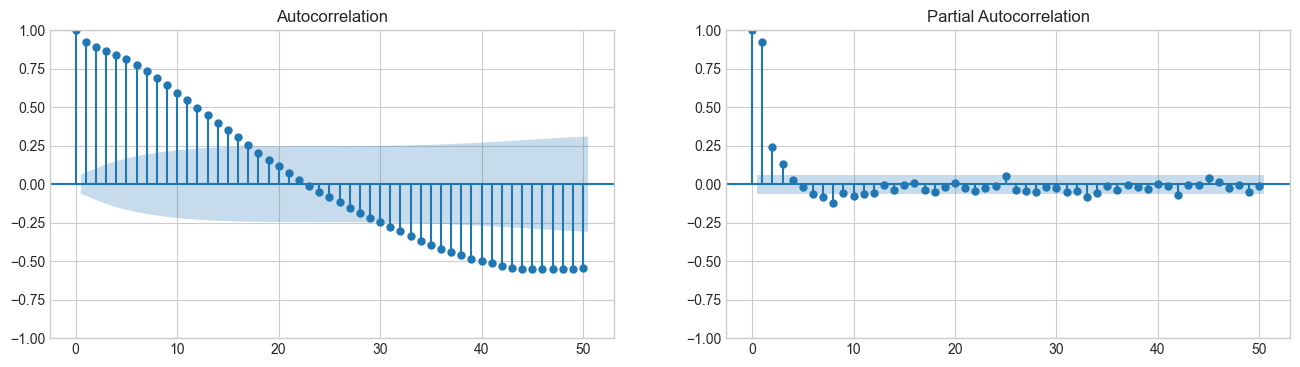

In [3]:
# Decompose a subset (e.g., first 500 hours ~ 3 weeks) to see daily patterns
subset = data_series.iloc[:500]
decomposition = seasonal_decompose(subset, model='additive', period=24)

fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.savefig(report_path / 'ts_decomposition.png')
plt.show()

# ACF and PACF to determine optimal lags
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data_series.iloc[:1000], lags=50, ax=ax[0])
plot_pacf(data_series.iloc[:1000], lags=50, ax=ax[1])
plt.savefig(report_path / 'acf_pacf.png')
plt.show()

## 3. Advanced Feature Engineering
Standard Linear Regression failed to capture complex cyclical patterns. We will construct a rich feature set.

We create a DataFrame where the index is time `t`, and columns are features derived from previous time steps `t-1`, `t-2`...

In [4]:
def create_features(series, window_size=168): # 168 hours = 1 week
    X = pd.DataFrame(index=series.index)
    y = series
    
    # 1. Base Lags (t-1 to t-6 were given, but we will generate them freshly to be consistent)
    for i in range(1, 7):
        X[f'Lag_{i}'] = series.shift(i)
        
    # 2. Daily Lags (t-24, t-48)
    X['Lag_24'] = series.shift(24)
    X['Lag_48'] = series.shift(48)
    
    # 3. Weekly Lag (t-168)
    X['Lag_168'] = series.shift(168)
    
    # 4. Rolling Statistics (Volatility/Trend)
    # Mean of last 6 hours
    X['Rolling_Mean_6'] = series.shift(1).rolling(window=6).mean()
    # Std of last 24 hours
    X['Rolling_Std_24'] = series.shift(1).rolling(window=24).std()
    
    # 5. Time Features (Synthetic Hour)
    # Since we don't have a real datetime index, we assume row 0 is Hour 0 (or unknown start) 
    # We iterate 0..23 repeatedly.
    hour_series = X.index % 24
    
    # Cyclical Encoding (Sin/Cos) - CRITICAL for time data
    X['Hour_Sin'] = np.sin(2 * np.pi * hour_series / 24)
    X['Hour_Cos'] = np.cos(2 * np.pi * hour_series / 24)
    
    # Drop NaNs generated by shifting (first 168 rows will be lost)
    valid_idx = X.dropna().index
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]
    
    return X, y

print("Generating advanced features...")
X_eng, y_eng = create_features(data_series)

print(f"Feature Set Shape: {X_eng.shape}")
display(X_eng.head())

Generating advanced features...
Feature Set Shape: (139403, 13)


,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_24,Lag_48,Lag_168,Rolling_Mean_6,Rolling_Std_24,Hour_Sin,Hour_Cos
168,507.177033,473.684211,435.406699,373.205742,411.483254,363.636364,291.866029,100.478469,425.837321,427.432217,66.799336,0.000000,1.000000
169,468.899521,507.177033,473.684211,435.406699,373.205742,411.483254,339.712919,105.263158,397.129187,444.976077,70.040168,0.258819,0.965926
170,473.684211,468.899521,507.177033,473.684211,435.406699,373.205742,387.559809,95.693780,344.497608,455.342903,73.975103,0.500000,0.866025
171,569.377990,473.684211,468.899521,507.177033,473.684211,435.406699,296.650718,81.339713,344.497608,488.038277,85.276552,0.707107,0.707107
172,502.392344,569.377990,473.684211,468.899521,507.177033,473.684211,263.157895,66.985646,311.004785,499.202552,88.044373,0.866025,0.500000


## 4. Train/Test Split & Scaling
Using 80/20 Time-based split. Standardizing data is important for Neural Networks.

In [5]:
# Standard Sequential Split
train_size = int(len(X_eng) * 0.8)

X_train, X_test = X_eng.iloc[:train_size], X_eng.iloc[train_size:]
y_train, y_test = y_eng.iloc[:train_size], y_eng.iloc[train_size:]

# Scaling (Fit on Train, Transform Test)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_sc = scaler_X.fit_transform(X_train)
X_test_sc = scaler_X.transform(X_test)

y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Train samples: 111522, Test samples: 27881


In [6]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## 5. Model Training and Evaluation

In [7]:
# 1. Linear Regression (on Enhanced Features)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mape_lr = calculate_mape(y_test, y_pred_lr)
print(f"Linear Regression (Enhanced Features) MAPE: {mape_lr:.4f}%")

Linear Regression (Enhanced Features) MAPE: 12.5141%


In [8]:
# 2. XGBoost (Gradient Boosting)
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=5, 
    early_stopping_rounds=50,
    n_jobs=-1
)

# XGBoost needs validation set for early stopping
xgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)
mape_xgb = calculate_mape(y_test, y_pred_xgb)
print(f"XGBoost MAPE: {mape_xgb:.4f}%")

Training XGBoost...
XGBoost MAPE: 11.6382%


In [9]:
# 3. LSTM (Deep Learning)
# Reshape for LSTM: [Samples, Timesteps, Features]
# Here we treat the 'Features' (Lags etc) as the input vector for a single timestep interpretation 
# OR we can treat it as a sequence. Given our feature engineering (Lag columns), 
# we can treat this as a standard regression problem [Samples, 1, Features] for simplicity,
# or rebuild proper sequences (which is redundant as we already lagged the data).
# We will use [Samples, 1, Num_Features].

X_train_lstm = X_train_sc.reshape((X_train_sc.shape[0], 1, X_train_sc.shape[1]))
X_test_lstm = X_test_sc.reshape((X_test_sc.shape[0], 1, X_test_sc.shape[1]))

print(f"LSTM Input Shape: {X_train_lstm.shape}")

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(1, X_train_sc.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_lstm, y_train_sc, 
    epochs=20, 
    batch_size=64, 
    validation_data=(X_test_lstm, y_test_sc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

# Predict and inverse scale
y_pred_scaled = model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled).flatten()

mape_lstm = calculate_mape(y_test, y_pred_lstm)
print(f"LSTM MAPE: {mape_lstm:.4f}%")

LSTM Input Shape: (111522, 1, 13)
Epoch 1/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0085 - val_loss: 0.0038
Epoch 2/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 3/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 7/20
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0033 - val_loss: 0.0033
872/872 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
LSTM MAPE: 11.5321%


## 6. Final Model Comparison
Comparing all methods.

,Model,MAPE (%)
2,LSTM,11.532072
1,XGBoost,11.638168
0,Linear Reg (Enhanced),12.514104


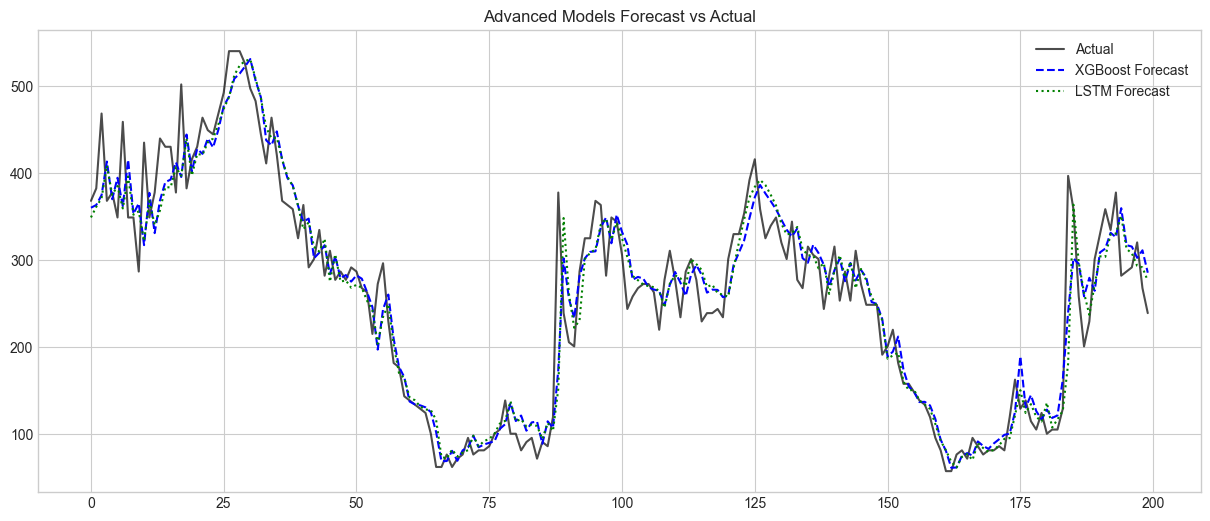

In [10]:
results = {
    'Model': ['Linear Reg (Enhanced)', 'XGBoost', 'LSTM'],
    'MAPE (%)': [mape_lr, mape_xgb, mape_lstm]
}

results_df = pd.DataFrame(results)
display(results_df.sort_values(by='MAPE (%)'))

# Plot Best Model Forecast (Subset)
subset_n = 200
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:subset_n], label='Actual', color='black', alpha=0.7)
plt.plot(y_pred_xgb[:subset_n], label='XGBoost Forecast', color='blue', linestyle='--')
if 'y_pred_lstm' in locals():
    plt.plot(y_pred_lstm[:subset_n], label='LSTM Forecast', color='green', linestyle=':')
plt.title('Advanced Models Forecast vs Actual')
plt.legend()
plt.savefig(report_path / 'advanced_model_comparison.png')
plt.show()